In [328]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.stats import norm


In [329]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

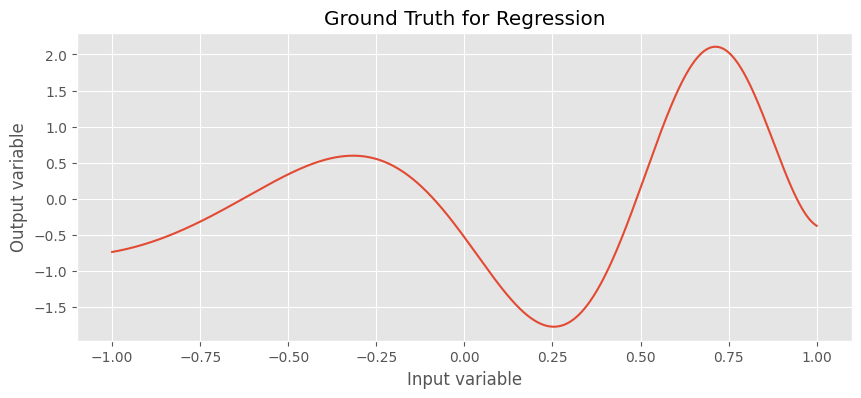

In [330]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return np.cos( 0.1*x**2 + 0.01*x - 1 ) + np.exp(0.1*x)

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(5*xs + 5)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

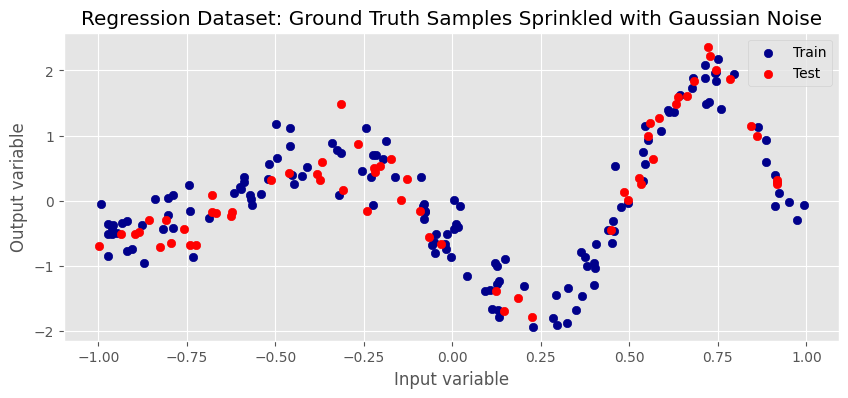

In [331]:
def gen_gaussian_noise(size=100, noise=0.5, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split)

np.random.seed(42)

x_tr, x_te, y_tr, y_te = gen_gaussian_noise(size=200, noise=0.3, split = 0.3)
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [332]:
class GaussianMeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=5e-2, prior_var=1):
        super(GaussianMeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var/4)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var/4)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    # def kl(self):
    #     weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
    #     bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
    #     return weight_kl + bias_kl
    def kl(self, param_sample):
        weights = param_sample[0]
        biases = param_sample[1]
        weight_kl = self.q_w().log_prob(weights) - self.p_w().log_prob(weights)
        bias_kl = self.q_b().log_prob(biases) - self.p_b().log_prob(biases)
        return weight_kl.sum(dim=[1,2]).mean(0) + bias_kl.sum(dim=[1,2]).mean(0)



    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        # print('dim weights', weights.shape)

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # print('dim biases', biases.shape)
        # print('dim x', x.shape)
        # print('dim x @ weights', (x @ weights).shape)
        
        # print('dim x @ weights + biases', (x @ weights + biases).shape)
        return x @ weights + biases, [weights, biases] # (num_samples, batch_size, output_dim).




class GaussianMeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.ELU(),
        noise_std = 1.0,
        prior_var = 1
    ):
        super(GaussianMeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(GaussianMeanFieldLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    GaussianMeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
            else:
                self.network.append(
                    GaussianMeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        param_samples = []
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            if isinstance(layer, GaussianMeanFieldLayer):
                x, param_sample = layer(x)
                param_samples.append(param_sample)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x, param_samples

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self,param_samples):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(param_samples[i//2]) for i, layer in enumerate(self.network) if isinstance(layer, GaussianMeanFieldLayer)])


    # def loss(self, x, y, num_samples=1):
    #     """Computes the ELBO and returns its negative"""

    #     y_pred = self.forward(x, num_samples=num_samples)
        
    #     exp_ll = self.ll(y, y_pred, num_samples=num_samples)
    #     kl = self.kl()

    #     return kl - exp_ll, exp_ll, kl
    
    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred, param_samples = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl(param_samples)

        return kl - exp_ll, exp_ll, kl


In [333]:
class T_MeanFieldLayer(nn.Module):
    """Represents a mean-field Student's t-distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, df, prior_var=1):
        super(T_MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.df = df
        self.prior_scale = np.sqrt(((df-2)/df * prior_var))
        
        # Prior parameters p(theta)
        self.w_loc_p = torch.zeros(input_dim, output_dim)
        self.w_log_scale_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(self.prior_scale))

        self.b_loc_p = torch.zeros(output_dim)
        self.b_log_scale_p = torch.ones(output_dim) * torch.log(torch.tensor(self.prior_scale))


        # Variational parameters q(theta)
        self.w_loc_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_scale_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(self.prior_scale/2)), requires_grad=True
        )  
        self.b_loc_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_scale_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(self.prior_scale/2)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.StudentT(self.df, self.w_loc_p, self.w_log_scale_p.exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.StudentT(self.df, self.b_loc_p, self.b_log_scale_p.exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.StudentT(self.df, self.w_loc_q, torch.exp(self.w_log_scale_q))

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.StudentT(self.df, self.b_loc_q, torch.exp(self.b_log_scale_q))
    
    # def kl(self, num_samples = 1):
    #     weight_samples = self.q_w().rsample((num_samples,))  # rsample allows for gradient propagation
    #     bias_samples = self.q_b().rsample((num_samples,))

    #     log_q_w = self.q_w().log_prob(weight_samples)  
    #     log_p_w = self.p_w().log_prob(weight_samples)

    #     log_q_b = self.q_b().log_prob(bias_samples)
    #     log_p_b = self.p_b().log_prob(bias_samples)

    #     weight_kl = (log_q_w - log_p_w).mean()  # Average over samples
    #     bias_kl = (log_q_b - log_p_b).mean()
    #     return weight_kl + bias_kl

    def kl(self, param_sample):
        weights = param_sample[0]
        biases = param_sample[1]
        weight_kl = self.q_w().log_prob(weights) - self.p_w().log_prob(weights)
        bias_kl = self.q_b().log_prob(biases) - self.p_b().log_prob(biases)
        return weight_kl.sum(dim=[1,2]).mean(0) + bias_kl.sum(dim=[1,2]).mean(0)

    

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # print(biases.shape)
        return x @ weights + biases, [weights, biases] # (num_samples, batch_size, output_dim).




class T_MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        df,
        activation = nn.ELU(),
        noise_std = 1.0,
        prior_var = 1
    ):
        super(T_MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(T_MeanFieldLayer(self.input_dim, self.hidden_dims[i], df=df, prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    T_MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, df=df, prior_var = prior_var)
                )
            else:
                self.network.append(
                    T_MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], df=df, prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        param_samples = []
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network

        for layer in self.network:
            if isinstance(layer, T_MeanFieldLayer):
                x, param_sample = layer(x)
                param_samples.append(param_sample)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x, param_samples

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self,param_samples):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(param_samples[i//2]) for i, layer in enumerate(self.network) if isinstance(layer, T_MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred, param_samples = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl(param_samples)

        return kl - exp_ll, exp_ll, kl

In [334]:
class Lap_MeanFieldLayer(nn.Module):
    """Represents a mean-field Student's t-distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, prior_var=1):
        super(Lap_MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior_scale = np.sqrt((prior_var/2))
        
        # Prior parameters p(theta)
        self.w_loc_p = torch.zeros(input_dim, output_dim)
        self.w_log_scale_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(self.prior_scale))

        self.b_loc_p = torch.zeros(output_dim)
        self.b_log_scale_p = torch.ones(output_dim) * torch.log(torch.tensor(self.prior_scale))


        # Variational parameters q(theta)
        self.w_loc_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_scale_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(self.prior_scale/2)), requires_grad=True
        )  
        self.b_loc_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_scale_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(self.prior_scale/2)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Laplace(self.w_loc_p, self.w_log_scale_p.exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Laplace(self.b_loc_p, self.b_log_scale_p.exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Laplace(self.w_loc_q, self.w_log_scale_q.exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Laplace(self.b_loc_q, self.b_log_scale_q.exp())
    

    def kl(self, param_sample):
        weights = param_sample[0]
        biases = param_sample[1]
        weight_kl = self.q_w().log_prob(weights) - self.p_w().log_prob(weights)
        bias_kl = self.q_b().log_prob(biases) - self.p_b().log_prob(biases)
        return weight_kl.sum(dim=[1,2]).mean(0) + bias_kl.sum(dim=[1,2]).mean(0)

    

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
    
        # print(biases.shape)
        return x @ weights + biases, [weights, biases] # (num_samples, batch_size, output_dim).




class Lap_MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.ELU(),
        noise_std = 1.0,
        prior_var = 1
    ):
        super(Lap_MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(Lap_MeanFieldLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    Lap_MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
            else:
                self.network.append(
                    Lap_MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        param_samples = []
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            if isinstance(layer, Lap_MeanFieldLayer):
                x, param_sample = layer(x)
                param_samples.append(param_sample)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x, param_samples

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self,param_samples):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(param_samples[i//2]) for i, layer in enumerate(self.network) if isinstance(layer, Lap_MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred, param_samples = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl(param_samples)

        return kl - exp_ll, exp_ll, kl

In [335]:
gaussian_bnn_model = GaussianMeanFieldBNN(1, [5, 5], 1, noise_std=0.3, prior_var = 0.4)
t_bnn_model = T_MeanFieldBNN(1, [5, 5], 1, df=5, noise_std=0.3, prior_var = 0.4)
lap_bnn_model = Lap_MeanFieldBNN(1, [5, 5], 1, noise_std=0.3, prior_var = 0.4)

g_opt = torch.optim.Adam(
    gaussian_bnn_model.parameters(),
    lr = 1e-2
)

t_opt = torch.optim.Adam(
    t_bnn_model.parameters(),
    lr = 1e-2
)

lap_opt = torch.optim.Adam(
    lap_bnn_model.parameters(),
    lr = 1e-2
)

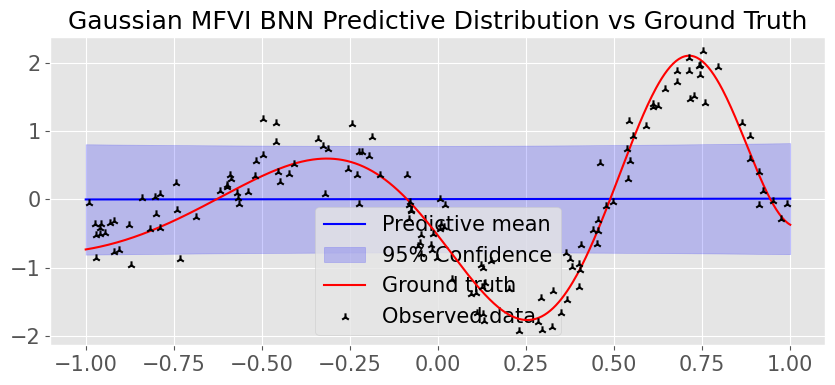

In [336]:
xs = np.linspace(-1, 1, 500)
num_samps = 1000

preds = gaussian_bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps)[0].squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

ys = normalised_ground_truth(xs)
plt.title("Gaussian MFVI BNN Predictive Distribution vs Ground Truth", fontsize=18)
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.legend(fontsize=15, loc='lower center')
# plt.xlim([-1, 1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

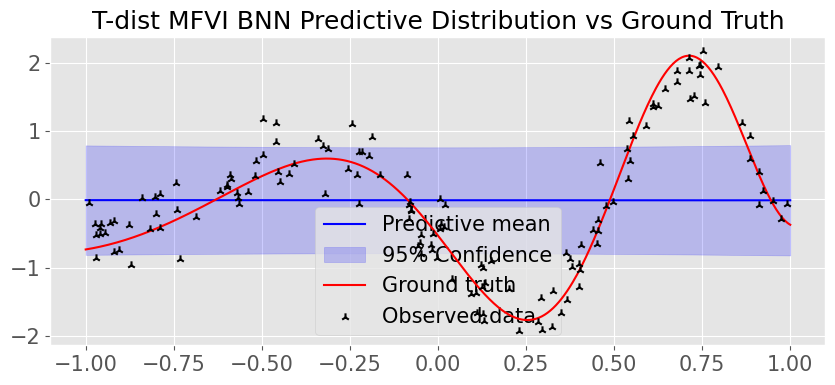

In [337]:
preds = t_bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps)[0].squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

ys = normalised_ground_truth(xs)
plt.title("T-dist MFVI BNN Predictive Distribution vs Ground Truth", fontsize=18)
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.legend(fontsize=15, loc='lower center')
# plt.xlim([-1, 1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

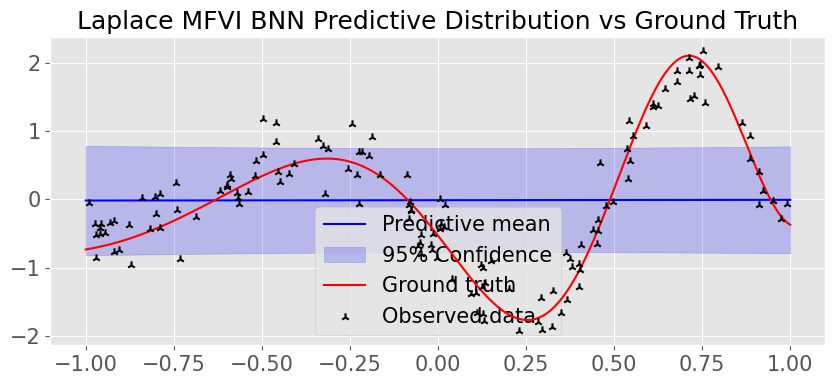

In [338]:
preds = lap_bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps)[0].squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

ys = normalised_ground_truth(xs)
plt.title("Laplace MFVI BNN Predictive Distribution vs Ground Truth", fontsize=18)
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.legend(fontsize=15, loc='lower center')
# plt.xlim([-1, 1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

100%|██████████| 5000/5000 [00:16<00:00, 308.10it/s]


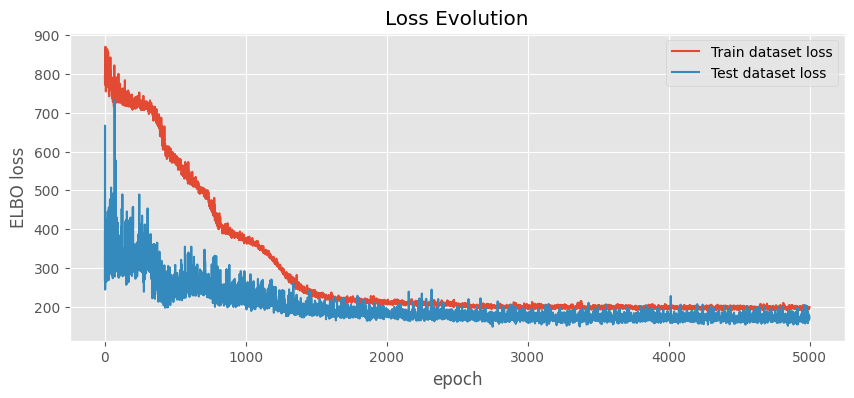

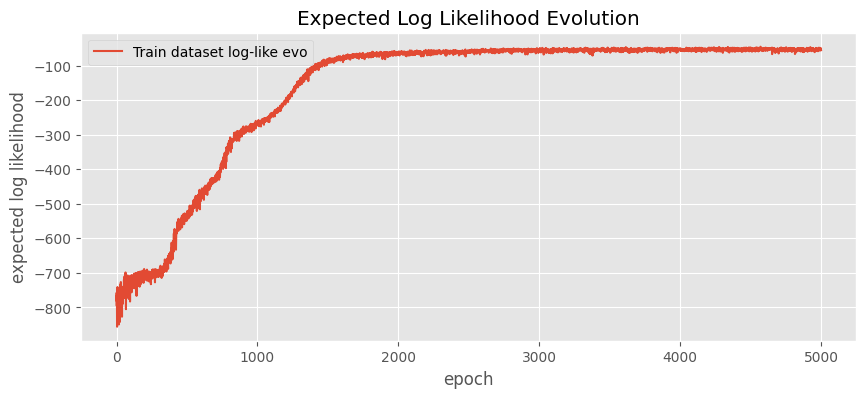

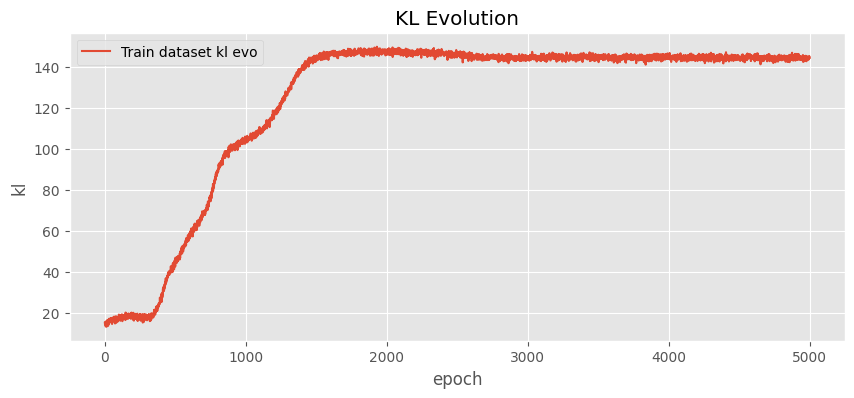

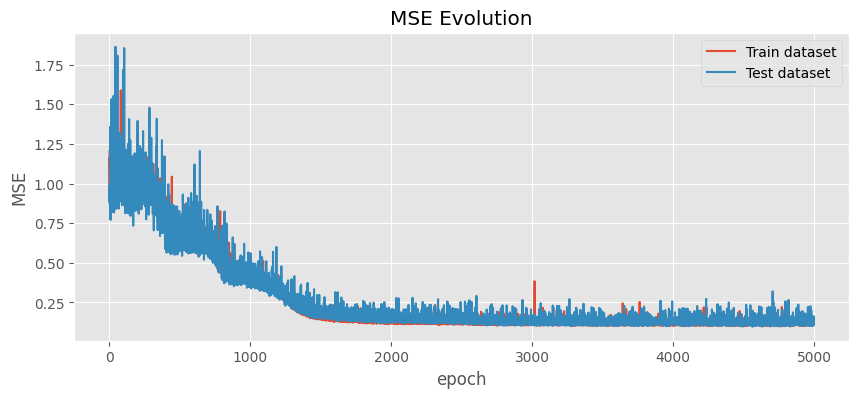

In [ ]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []
tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

min_epochs = 1000 
max_epochs = 5000
window_size = 5
tol = 0.7

for epoch in tqdm(range(max_epochs)):  # epochs
    g_opt.zero_grad()

    l, ll, kl = gaussian_bnn_model.loss(x_tr, y_tr, num_samples = 20)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(gaussian_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())

    te_loss_evo.append(gaussian_bnn_model.loss(x_te, y_te)[0].item())
    te_mse_loss_evo.append(aux_loss(gaussian_bnn_model(x_te)[0], y_te.unsqueeze(0)).item())

    l.backward()
    g_opt.step()

    # Check for convergence after `min_epochs`
    if epoch > min_epochs:
        mean_change = np.mean(np.abs(np.diff(te_loss_evo[-window_size:])))
        if mean_change < tol:
            print(f"Converged at epoch {epoch} with mean test loss change {mean_change:.6f}")
            break

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

In [340]:
# tr_loss_evo = []
# tr_ll_evo = []
# tr_kl_evo = []
# te_loss_evo = []

# tr_mse_loss_evo = []
# te_mse_loss_evo = []
# aux_loss = nn.MSELoss()

# for epoch in tqdm(range(4000)):  # epochs
#     t_opt.zero_grad()

#     l, ll, kl = t_bnn_model.loss(x_tr, y_tr, num_samples = 10)
#     tr_loss_evo.append(l.item())
#     tr_ll_evo.append(ll.item())
#     tr_kl_evo.append(kl.item())
#     tr_mse_loss_evo.append(aux_loss(t_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())

#     te_loss_evo.append(t_bnn_model.loss(x_te, y_te)[0].item())
#     te_mse_loss_evo.append(aux_loss(t_bnn_model(x_te)[0], y_te.unsqueeze(0)).item())

#     l.backward()
#     t_opt.step()

# plt.rcParams["figure.figsize"] = (10, 4)

# plt.plot(tr_loss_evo, label='Train dataset loss')
# plt.plot(te_loss_evo, label='Test dataset loss')
# plt.ylabel('ELBO loss')
# plt.xlabel('epoch')
# plt.legend()
# plt.title('Loss Evolution')
# plt.show()

# plt.plot(tr_ll_evo, label='Train dataset log-like evo')
# plt.ylabel('expected log likelihood')
# plt.xlabel('epoch')
# plt.legend()
# plt.title('Expected Log Likelihood Evolution')
# plt.show()

# plt.plot(tr_kl_evo, label='Train dataset kl evo')
# plt.ylabel('kl')
# plt.xlabel('epoch')
# plt.legend()
# plt.title('KL Evolution')
# plt.show()

# plt.plot(tr_mse_loss_evo, label='Train dataset')
# plt.plot(te_mse_loss_evo, label='Test dataset')
# plt.ylabel('MSE')
# plt.xlabel('epoch')
# plt.legend()
# plt.title('MSE Evolution')
# plt.show()

In [341]:
# tr_loss_evo = []
# tr_ll_evo = []
# tr_kl_evo = []
# te_loss_evo = []

# tr_mse_loss_evo = []
# te_mse_loss_evo = []
# aux_loss = nn.MSELoss()

# for epoch in tqdm(range(4000)):  # epochs
#     lap_opt.zero_grad()

#     l, ll, kl = lap_bnn_model.loss(x_tr, y_tr, num_samples = 10)
#     tr_loss_evo.append(l.item())
#     tr_ll_evo.append(ll.item())
#     tr_kl_evo.append(kl.item())
#     tr_mse_loss_evo.append(aux_loss(lap_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())

#     te_loss_evo.append(lap_bnn_model.loss(x_te, y_te)[0].item())
#     te_mse_loss_evo.append(aux_loss(lap_bnn_model(x_te)[0], y_te.unsqueeze(0)).item())

#     l.backward()
#     lap_opt.step()

# plt.rcParams["figure.figsize"] = (10, 4)

# plt.plot(tr_loss_evo, label='Train dataset loss')
# plt.plot(te_loss_evo, label='Test dataset loss')
# plt.ylabel('ELBO loss')
# plt.xlabel('epoch')
# plt.legend()
# plt.title('Loss Evolution')
# plt.show()

# plt.plot(tr_ll_evo, label='Train dataset log-like evo')
# plt.ylabel('expected log likelihood')
# plt.xlabel('epoch')
# plt.legend()
# plt.title('Expected Log Likelihood Evolution')
# plt.show()

# plt.plot(tr_kl_evo, label='Train dataset kl evo')
# plt.ylabel('kl')
# plt.xlabel('epoch')
# plt.legend()
# plt.title('KL Evolution')
# plt.show()

# plt.plot(tr_mse_loss_evo, label='Train dataset')
# plt.plot(te_mse_loss_evo, label='Test dataset')
# plt.ylabel('MSE')
# plt.xlabel('epoch')
# plt.legend()
# plt.title('MSE Evolution')
# plt.show()

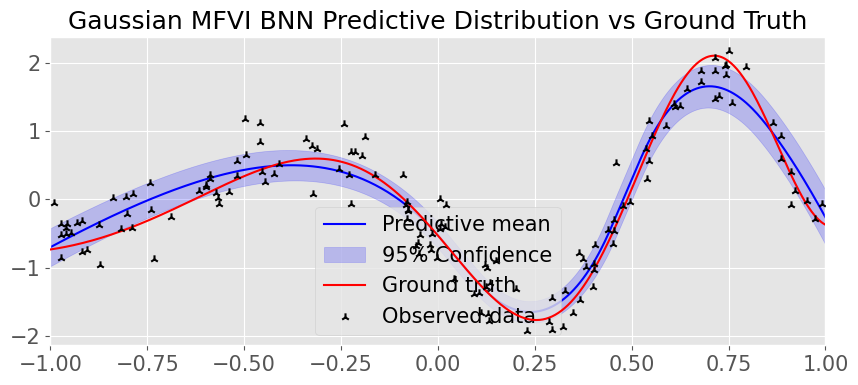

In [342]:
xs = np.linspace(-1, 1, 500)
num_samps = 1000

preds = gaussian_bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps)[0].squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

ys = normalised_ground_truth(xs)
plt.title("Gaussian MFVI BNN Predictive Distribution vs Ground Truth", fontsize=18)
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.legend(fontsize=15, loc='lower center')
plt.xlim([-1, 1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [343]:
# xs = np.linspace(-1, 1, 500)
# num_samps = 1000

# preds = t_bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps)[0].squeeze(-1).detach().numpy()
# pred_mean = preds.mean(0)
# pred_std = preds.std(0)
# plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
# plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

# ys = normalised_ground_truth(xs)
# plt.title("T-dist MFVI BNN Predictive Distribution vs Ground Truth", fontsize=18)
# plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
# plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
# plt.legend(fontsize=15, loc='lower center')
# plt.xlim([-1, 1])
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# # plt.grid()
# plt.show()

In [344]:
# xs = np.linspace(-1, 1, 500)
# num_samps = 1000

# preds = lap_bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps)[0].squeeze(-1).detach().numpy()
# pred_mean = preds.mean(0)
# pred_std = preds.std(0)
# plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
# plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

# ys = normalised_ground_truth(xs)
# plt.title("Lap MFVI BNN Predictive Distribution vs Ground Truth", fontsize=18)
# plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
# plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
# plt.legend(fontsize=15, loc='lower center')
# plt.xlim([-1, 1])
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# # plt.grid()
# plt.show()

In [345]:
# alpha_values = np.arange(0.05, 1.0, 0.1)
# num_splits = 4  # Number of train/test splits
# num_samples = 1000  # BNN posterior samples
# epochs = 2000  # Training epochs

# mcp_results_t = {alpha: [] for alpha in alpha_values}
# mcp_results_gaussian = {alpha: [] for alpha in alpha_values}
# mcp_results_lap = {alpha: [] for alpha in alpha_values}

# mcp_values = []



#     # Compute PICP on a large test set
# x_te_dense = torch.FloatTensor(np.linspace(-1, 1, 1000)).unsqueeze(-1)
# posterior_samples_gaussian  = gaussian_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # Shape: (num_samples, 1000)
# posterior_samples_t = t_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # (num_samples, 1000)
# posterior_samples_lap = lap_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # (num_samples, 1000)

# true_mean = normalised_ground_truth(x_te_dense)  # True function values
# noise_std = 0.3  # Known noise std

# for alpha in alpha_values:
#     # Compute quantiles for both models
#     lower_bounds_t = np.quantile(posterior_samples_t, alpha / 2, axis=0)
#     upper_bounds_t = np.quantile(posterior_samples_t, 1 - alpha / 2, axis=0)

#     lower_bounds_gaussian = np.quantile(posterior_samples_gaussian, alpha / 2, axis=0)
#     upper_bounds_gaussian = np.quantile(posterior_samples_gaussian, 1 - alpha / 2, axis=0)

#     lower_bounds_lap = np.quantile(posterior_samples_lap, alpha / 2, axis=0)
#     upper_bounds_lap = np.quantile(posterior_samples_lap, 1 - alpha / 2, axis=0)

#     # Compute coverage probabilities
#     coverage_probs_t = norm.cdf(upper_bounds_t, loc=true_mean, scale=noise_std) - \
#                        norm.cdf(lower_bounds_t, loc=true_mean, scale=noise_std)

#     coverage_probs_gaussian = norm.cdf(upper_bounds_gaussian, loc=true_mean, scale=noise_std) - \
#                               norm.cdf(lower_bounds_gaussian, loc=true_mean, scale=noise_std)
    
#     coverage_probs_lap = norm.cdf(upper_bounds_lap, loc=true_mean, scale=noise_std) - \
#                               norm.cdf(lower_bounds_lap, loc=true_mean, scale=noise_std)

#     # Store results
#     mcp_results_t[alpha].append(np.mean(coverage_probs_t))
#     mcp_results_gaussian[alpha].append(np.mean(coverage_probs_gaussian))
#     mcp_results_lap[alpha].append(np.mean(coverage_probs_lap))



# # Print final MCP values
# print("\nMCP results for t-BNN:")
# for alpha in alpha_values:
#     print(f"MCP (1-alpha={1-alpha:.2f}): {np.mean(mcp_results_t[alpha]):.4f}")

# print("\nMCP results for Gaussian-BNN:")
# for alpha in alpha_values:
#     print(f"MCP (1-alpha={1-alpha:.2f}): {np.mean(mcp_results_gaussian[alpha]):.4f}")

# print("\nMCP results for Laplace-BNN:")
# for alpha in alpha_values:
#     print(f"MCP (1-alpha={1-alpha:.2f}): {np.mean(mcp_results_lap[alpha]):.4f}")

In [346]:
split_dict = {split: [] for split in range(num_splits)}
metrics_dict = {'gaussian':split_dict.copy(), 't':split_dict.copy(), 'lap':split_dict.copy()}

tr_loss_evo = metrics_dict.copy()
tr_ll_evo = metrics_dict.copy()
tr_kl_evo = metrics_dict.copy()
te_loss_evo = metrics_dict.copy()
tr_mse_loss_evo = metrics_dict.copy()
te_mse_loss_evo = metrics_dict.copy()

tr_loss_evo

{'gaussian': {0: [],
  1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: [],
  16: [],
  17: [],
  18: [],
  19: []},
 't': {0: [],
  1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: [],
  16: [],
  17: [],
  18: [],
  19: []},
 'lap': {0: [],
  1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: [],
  16: [],
  17: [],
  18: [],
  19: []}}

In [347]:
te_loss_evo

{'gaussian': {0: [],
  1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: [],
  16: [],
  17: [],
  18: [],
  19: []},
 't': {0: [],
  1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: [],
  16: [],
  17: [],
  18: [],
  19: []},
 'lap': {0: [],
  1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: [],
  16: [],
  17: [],
  18: [],
  19: []}}

In [348]:
alpha_values = np.arange(0.05, 1.0, 0.05)
num_splits = 20  # Number of train/test splits
num_samples = 1000  # BNN posterior samples
noise = 0.3

min_epochs = 1000 
max_epochs = 5000
window_size = 5
tol = 0.8

split_dict = {split: [] for split in range(num_splits)}
metrics_dict = {'gaussian':split_dict.copy(), 't':split_dict.copy(), 'lap':split_dict.copy()}

tr_loss_evo = metrics_dict.copy()
tr_ll_evo = metrics_dict.copy()
tr_kl_evo = metrics_dict.copy()
te_loss_evo = metrics_dict.copy()
tr_mse_loss_evo = metrics_dict.copy()
te_mse_loss_evo = metrics_dict.copy()

aux_loss = nn.MSELoss()

mcp_results_t = {alpha: [] for alpha in alpha_values}
mcp_results_gaussian = {alpha: [] for alpha in alpha_values}
mcp_results_lap = {alpha: [] for alpha in alpha_values}

mcp_values = []
x_te_dense = torch.FloatTensor(np.linspace(-1, 1, 1000)).unsqueeze(-1)

for split in tqdm(range(num_splits)):

    # Generate new dataset
    x_tr, x_te, y_tr, y_te = gen_gaussian_noise(size=200, noise=noise, split=0.5) # 100 to train
    x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
    y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
    x_te = torch.FloatTensor(x_te).unsqueeze(-1)
    y_te = torch.FloatTensor(y_te).unsqueeze(-1)
   
    # Initialize a new BNN
    gaussian_bnn_model = GaussianMeanFieldBNN(1, [5, 5], 1, noise_std=noise, prior_var = 0.4)
    t_bnn_model = T_MeanFieldBNN(1, [5, 5], 1, df=5, noise_std=noise, prior_var = 0.4)
    lap_bnn_model = Lap_MeanFieldBNN(1, [5, 5], 1, noise_std=noise, prior_var = 0.4)

    g_opt = torch.optim.Adam(
        gaussian_bnn_model.parameters(),
        lr = 1e-2
    )

    t_opt = torch.optim.Adam(
        t_bnn_model.parameters(),
        lr = 1e-2
    )

    lap_opt = torch.optim.Adam(
        lap_bnn_model.parameters(),
        lr = 1e-2
    )
        
    # Train all 3 models
    for epoch in range(max_epochs):

        g_opt.zero_grad()
        g_l, g_ll, g_kl = gaussian_bnn_model.loss(x_tr, y_tr, num_samples=20)

        tr_loss_evo['gaussian'][split].append(g_l.item())
        tr_ll_evo['gaussian'][split].append(g_ll.item())
        tr_kl_evo['gaussian'][split].append(g_kl.item())
        tr_mse_loss_evo['gaussian'][split].append(aux_loss(gaussian_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())
        te_loss_evo['gaussian'][split].append(gaussian_bnn_model.loss(x_te, y_te)[0].item())
        te_mse_loss_evo['gaussian'][split].append(aux_loss(gaussian_bnn_model(x_te)[0], y_te.unsqueeze(0)).item())

        g_l.backward()
        g_opt.step()

        # Check for convergence after `min_epochs`
        if epoch > min_epochs:
            mean_change = np.mean(np.abs(np.diff(te_loss_evo['gaussian'][split][-window_size:])))
            if mean_change < tol:
                # print(f"Converged at epoch {epoch} with mean test loss change {mean_change:.6f}")
                break

    for epoch in range(max_epochs):
        t_opt.zero_grad()
        t_l, t_ll, t_kl = t_bnn_model.loss(x_tr, y_tr, num_samples=20)

        tr_loss_evo['t'][split].append(t_l.item())
        tr_ll_evo['t'][split].append(t_ll.item())
        tr_kl_evo['t'][split].append(t_kl.item())
        tr_mse_loss_evo['t'][split].append(aux_loss(t_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())
        te_loss_evo['t'][split].append(t_bnn_model.loss(x_te, y_te)[0].item())
        te_mse_loss_evo['t'][split].append(aux_loss(t_bnn_model(x_te)[0], y_te.unsqueeze(0)).item())

        t_l.backward()
        t_opt.step()

        # Check for convergence after `min_epochs`
        if epoch > min_epochs:
            mean_change = np.mean(np.abs(np.diff(te_loss_evo['t'][split][-window_size:])))
            if mean_change < tol:
                # print(f"Converged at epoch {epoch} with mean test loss change {mean_change:.6f}")
                break

    for epoch in range(max_epochs):
        lap_opt.zero_grad()
        lap_l, lap_ll, lap_kl = lap_bnn_model.loss(x_tr, y_tr, num_samples=20)

        tr_loss_evo['lap'][split].append(t_l.item())
        tr_ll_evo['lap'][split].append(t_ll.item())
        tr_kl_evo['lap'][split].append(t_kl.item())
        tr_mse_loss_evo['lap'][split].append(aux_loss(lap_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())
        te_loss_evo['lap'][split].append(lap_bnn_model.loss(x_te, y_te)[0].item())
        te_mse_loss_evo['lap'][split].append(aux_loss(lap_bnn_model(x_te)[0], y_te.unsqueeze(0)).item())

        lap_l.backward()
        lap_opt.step()

        # Check for convergence after `min_epochs`
        if epoch > min_epochs:
            mean_change = np.mean(np.abs(np.diff(te_loss_evo['lap'][split][-window_size:])))
            if mean_change < tol:
                # print(f"Converged at epoch {epoch} with mean test loss change {mean_change:.6f}")
                break


    # Compute PICP on a large test set
    posterior_samples_gaussian  = gaussian_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # Shape: (num_samples, 1000)
    posterior_samples_t = t_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # (num_samples, 1000)
    posterior_samples_lap = lap_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # (num_samples, 1000)
    
true_mean = normalised_ground_truth(x_te_dense)  # True function values

for alpha in alpha_values:
    # Compute quantiles for both models
    lower_bounds_t = np.quantile(posterior_samples_t, alpha / 2, axis=0)
    upper_bounds_t = np.quantile(posterior_samples_t, 1 - alpha / 2, axis=0)

    lower_bounds_gaussian = np.quantile(posterior_samples_gaussian, alpha / 2, axis=0)
    upper_bounds_gaussian = np.quantile(posterior_samples_gaussian, 1 - alpha / 2, axis=0)

    lower_bounds_lap = np.quantile(posterior_samples_lap, alpha / 2, axis=0)
    upper_bounds_lap = np.quantile(posterior_samples_lap, 1 - alpha / 2, axis=0)

    # Compute coverage probabilities
    coverage_probs_t = norm.cdf(upper_bounds_t, loc=true_mean, scale=noise) - \
                       norm.cdf(lower_bounds_t, loc=true_mean, scale=noise)

    coverage_probs_gaussian = norm.cdf(upper_bounds_gaussian, loc=true_mean, scale=noise) - \
                              norm.cdf(lower_bounds_gaussian, loc=true_mean, scale=noise)
    
    coverage_probs_lap = norm.cdf(upper_bounds_lap, loc=true_mean, scale=noise) - \
                              norm.cdf(lower_bounds_lap, loc=true_mean, scale=noise)

    # Store results
    mcp_results_t[alpha].append(np.mean(coverage_probs_t))
    mcp_results_gaussian[alpha].append(np.mean(coverage_probs_gaussian))
    mcp_results_lap[alpha].append(np.mean(coverage_probs_lap))


# for alpha in alpha_values:
#     MCP = np.mean(mcp_results[alpha])
#     print(f"MCP (1-alpha={1-alpha:.2f}): {MCP:.4f}")

100%|██████████| 20/20 [18:19<00:00, 55.00s/it]
/var/folders/d5/bt4mpp9n3gngv4q0rms4ylwm0000gn/T/ipykernel_30511/94810905.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.cos( 0.1*x**2 + 0.01*x - 1 ) + np.exp(0.1*x)


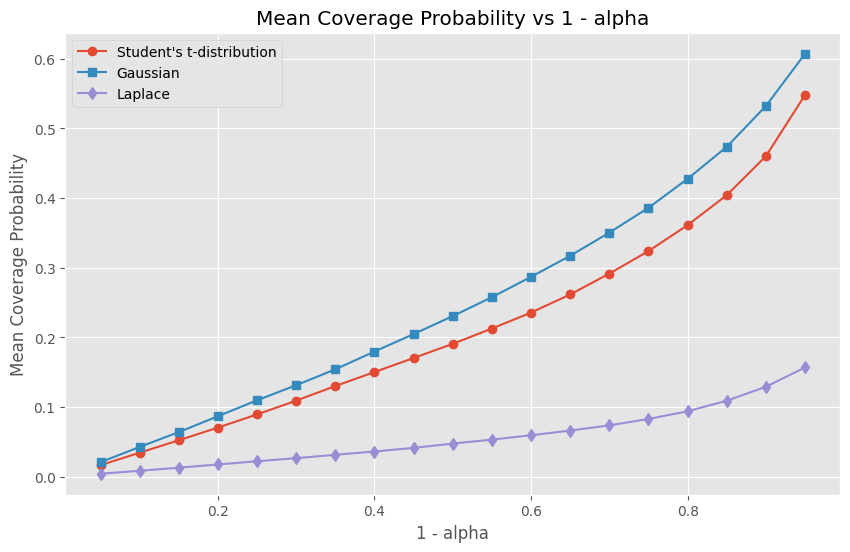

In [349]:
mcp_t = [mcp_results_t[alpha] for alpha in alpha_values]
mcp_gaussian = [mcp_results_gaussian[alpha] for alpha in alpha_values]
mcp_lap = [mcp_results_lap[alpha] for alpha in alpha_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(1-alpha_values, mcp_t, label='Student\'s t-distribution', marker='o')
plt.plot(1-alpha_values, mcp_gaussian, label='Gaussian', marker='s')
plt.plot(1-alpha_values, mcp_lap, label='Laplace', marker='d')

# Add labels, title, and legend
plt.xlabel('1 - alpha')
plt.ylabel('Mean Coverage Probability')
plt.title('Mean Coverage Probability vs 1 - alpha')
plt.legend()
plt.grid(True)
plt.show()

In [350]:
# tr_loss_evo = np.array(tr_loss_evo['gaussian']).reshape((20,4000))
# tr_ll_evo = np.array(tr_ll_evo['gaussian']).reshape((20,4000))
# tr_kl_evo = np.array(tr_kl_evo['gaussian']).reshape((20,4000))
# te_loss_evo = np.array(te_loss_evo['gaussian']).reshape((20,4000))
# tr_mse_loss_evo = np.array(tr_mse_loss_evo['gaussian']).reshape((20,4000))
# te_mse_loss_evo = np.array(te_mse_loss_evo['gaussian']).reshape((20,4000))